In [1]:
import torch
import torchaudio
import json
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import random
import soundfile
import scipy.signal
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

### Создаём датасет

In [2]:
class AudioDataset(Dataset):
    def __init__(self, audio_dir, bounds_file=None, mode='train', sample_rate=16000):
        self.audio_dir = Path(audio_dir)
        self.sample_rate = sample_rate
        self.mode = mode
        
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=400,
            hop_length=160,
            n_mels=80
        )
        
        self.files = list(self.audio_dir.glob('*.opus'))
        
        if bounds_file:
            with open(bounds_file, 'r') as f:
                self.bounds = json.load(f)
        else:
            self.bounds = {}
    
    def __len__(self):
        return len(self.files)
    
    def _get_mel(self, waveform):
        mel_spec = self.mel_transform(torch.tensor(waveform[None, :], dtype=torch.float32))
        mel_spec = torchaudio.transforms.AmplitudeToDB()(mel_spec)
        if mel_spec.shape[0] > 1:
            mel_spec = mel_spec.mean(dim=0, keepdim=True)
        mel_spec = mel_spec.squeeze(0).transpose(0, 1)
        return mel_spec
    
    def __getitem__(self, idx):
        file_path = self.files[idx]
        file_id = file_path.stem
        
        waveform, sample_rate = soundfile.read(str(file_path))
        
        if len(waveform.shape) > 1:
            waveform = waveform.mean(axis=1)
        
        if sample_rate != self.sample_rate:
            resample_ratio = self.sample_rate / sample_rate
            new_length = int(len(waveform) * resample_ratio)
            waveform = scipy.signal.resample(waveform, new_length)
        
        mel_spec = self._get_mel(waveform)
        
        if self.mode == 'train' and file_id in self.bounds:
            label = 1
        elif self.mode == 'train':
            label = 0
        else:
            label = -1
        
        return mel_spec, torch.tensor(label, dtype=torch.long)

### Класс аугментации

In [3]:
class SpecAugment:
    def __init__(self, freq_mask_param=27, time_mask_param=100):
        self.freq_mask_param = freq_mask_param
        self.time_mask_param = time_mask_param
    
    def transform(self, spec):
        output_spec = spec.clone()
        
        f = torch.randint(0, self.freq_mask_param, (1,)).item()
        f0 = torch.randint(0, max(1, output_spec.size(-2) - f), (1,)).item()
        output_spec[..., f0:f0+f, :] = 0
        
        t = torch.randint(0, self.time_mask_param, (1,)).item()
        t0 = torch.randint(0, max(1, output_spec.size(-1) - t), (1,)).item()
        output_spec[..., t0:t0+t] = 0
        
        return output_spec

### Создаём модель по частям

In [4]:
class ConvSubsampling(nn.Module):
    def __init__(self, input_dim=80, output_dim=256):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, output_dim, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.linear = nn.Linear(output_dim * (input_dim // 8), output_dim)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv_layers(x)
        batch, channels, time, freq = x.size()
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch, time, -1)
        x = self.linear(x)
        return x

In [5]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim=256, heads=4, dropout=0.1):
        super().__init__()
        self.heads = heads
        self.dim = dim
        self.head_dim = dim // heads
        
        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        batch, time, dim = x.shape
        qkv = self.qkv(x).reshape(batch, time, 3, self.heads, self.head_dim)
        q, k, v = qkv.permute(2, 0, 3, 1, 4)
        
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
            
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).reshape(batch, time, dim)
        out = self.proj(out)
        return out

In [6]:
class ConformerBlock(nn.Module):
    def __init__(self, dim=256, heads=4, conv_kernel=31, dropout=0.1):
        super().__init__()
        
        self.ff1 = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim * 4),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )
        
        self.attention = nn.Sequential(
            nn.LayerNorm(dim),
            MultiHeadSelfAttention(dim, heads, dropout)
        )
        
        self.conv_ln = nn.LayerNorm(dim)
        self.conv = nn.Sequential(
            nn.Conv1d(dim, dim * 2, 1),
            nn.GLU(dim=1),
            nn.Conv1d(dim, dim, conv_kernel, padding=conv_kernel//2, groups=dim),
            nn.BatchNorm1d(dim),
            nn.SiLU(),
            nn.Conv1d(dim, dim, 1),
            nn.Dropout(dropout)
        )
        
        self.ff2 = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim * 4),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )

        self.layer_norm = nn.LayerNorm(dim)

    def forward(self, x):
        x = x + 0.5 * self.ff1(x)
        x = x + self.attention(x)
        
        residual = x
        x = self.conv_ln(x)
        x = x.transpose(1, 2)
        x = self.conv(x)
        x = x.transpose(1, 2)
        x = residual + x
        
        x = x + 0.5 * self.ff2(x)
        return self.layer_norm(x)

In [7]:
class AudioClassifier(nn.Module):
    def __init__(self, input_dim=80, num_classes=2, dim=256, num_blocks=2, heads=4):
        super().__init__()
        
        self.conv_subsampling = ConvSubsampling(input_dim, dim)
        
        self.conformer_blocks = nn.ModuleList([
            ConformerBlock(dim, heads) for _ in range(num_blocks)
        ])
        
        self.classifier = nn.Sequential(
            nn.Linear(dim, dim // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(dim // 2, num_classes)
        )
        
    def forward(self, x):
        x = self.conv_subsampling(x)
        
        for block in self.conformer_blocks:
            x = block(x)
            
        x = x.mean(dim=1)
        x = self.classifier(x)
        return x

### Вспомогательные функции

In [8]:
def collate_fn(batch):
    mels, labels = zip(*batch)
    
    mels_padded = torch.nn.utils.rnn.pad_sequence(
        [mel for mel in mels], 
        batch_first=True, 
        padding_value=0.0
    )
    
    labels = torch.stack(labels)
    return mels_padded, labels

In [9]:
def calculate_harmonic_metric(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    NUM_POS = np.sum(y_true == 1)
    NUM_NEG = np.sum(y_true == 0)
    
    if NUM_POS > 0:
        FRR = FN / NUM_POS
    else:
        FRR = 0.0
    
    if NUM_NEG > 0:
        FAR = FP / NUM_NEG
    else:
        FAR = 0.0
    
    score = (2 * (1 - FRR) * (1 - FAR)) / ((1 - FRR) + (1 - FAR)) if ((1 - FRR) + (1 - FAR)) > 0 else 0.0
    
    return score, FRR, FAR, TP, TN, FP, FN

def train_model(model, train_loader, val_loader, epochs=10, lr=3e-4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    spec_aug = SpecAugment()
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    val_harmonic_scores = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        for mels, labels in train_pbar:
            if random.random() < 0.5:
                mels = torch.stack([spec_aug.transform(mel) for mel in mels])
            
            mels, labels = mels.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(mels)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_val_labels = []
        all_val_preds = []
        
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
        with torch.no_grad():
            for mels, labels in val_pbar:
                mels, labels = mels.to(device), labels.to(device)
                outputs = model(mels)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
                
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(predicted.cpu().numpy())
                
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{100.*val_correct/val_total:.2f}%'
                })
        
        train_acc = 100. * correct / total
        val_acc = 100. * val_correct / val_total
        
        harmonic_score, FRR, FAR, TP, TN, FP, FN = calculate_harmonic_metric(
            np.array(all_val_labels), np.array(all_val_preds)
        )
        
        train_losses.append(train_loss/len(train_loader))
        train_accs.append(train_acc)
        val_losses.append(val_loss/len(val_loader))
        val_accs.append(val_acc)
        val_harmonic_scores.append(harmonic_score)
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
        print(f'Harmonic Score: {harmonic_score:.4f}, FRR: {FRR:.4f}, FAR: {FAR:.4f}')
        print(f'TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}')
        print('-' * 50)
        
        scheduler.step()
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.plot(val_harmonic_scores, label='Harmonic Score', color='green')
    plt.title('Harmonic Mean Score')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return model

In [10]:
def predict(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    predictions = []
    
    with torch.no_grad():
        for mels, _ in test_loader:
            mels = mels.to(device)
            outputs = model(mels)
            _, predicted = outputs.max(1)
            
            predictions.extend(predicted.cpu().numpy())
    
    return predictions

In [11]:
def create_submission(test_files, predictions, output_file='submission.csv'):
    with open(output_file, 'w') as f:
        f.write('id,label\n')
        for file_path, pred in zip(test_files, predictions):
            file_id = file_path.stem
            f.write(f'{file_id},{pred}\n')
    print(f'Submission saved to {output_file}')

### Непосредственно обучение и инференс модели

Training model...


Epoch 1/5 [Val]: 100%|██████████| 563/563 [09:39<00:00,  1.03s/it, Loss=0.3809, Acc=82.06%]


Epoch 1/5:
Train Loss: 0.6037, Train Acc: 64.95%
Val Loss: 0.4127, Val Acc: 82.06%
Harmonic Score: 0.8204, FRR: 0.1666, FAR: 0.1922
TP: 7523, TN: 7248, FP: 1725, FN: 1504
--------------------------------------------------


Epoch 2/5 [Val]: 100%|██████████| 563/563 [09:48<00:00,  1.04s/it, Loss=0.4285, Acc=83.72%]


Epoch 2/5:
Train Loss: 0.4567, Train Acc: 77.09%
Val Loss: 0.3628, Val Acc: 83.72%
Harmonic Score: 0.8206, FRR: 0.0466, FAR: 0.2797
TP: 8606, TN: 6463, FP: 2510, FN: 421
--------------------------------------------------


Epoch 3/5 [Val]: 100%|██████████| 563/563 [09:50<00:00,  1.05s/it, Loss=0.1504, Acc=88.66%]


Epoch 3/5:
Train Loss: 0.3968, Train Acc: 80.30%
Val Loss: 0.2741, Val Acc: 88.66%
Harmonic Score: 0.8866, FRR: 0.1086, FAR: 0.1182
TP: 8047, TN: 7912, FP: 1061, FN: 980
--------------------------------------------------


Epoch 4/5 [Val]: 100%|██████████| 563/563 [09:57<00:00,  1.06s/it, Loss=0.2307, Acc=90.09%]


Epoch 4/5:
Train Loss: 0.3537, Train Acc: 82.56%
Val Loss: 0.2518, Val Acc: 90.09%
Harmonic Score: 0.9009, FRR: 0.0978, FAR: 0.1004
TP: 8144, TN: 8072, FP: 901, FN: 883
--------------------------------------------------


Epoch 5/5 [Val]: 100%|██████████| 563/563 [09:49<00:00,  1.05s/it, Loss=0.0956, Acc=90.65%]


Epoch 5/5:
Train Loss: 0.3263, Train Acc: 83.90%
Val Loss: 0.2407, Val Acc: 90.65%
Harmonic Score: 0.9057, FRR: 0.0686, FAR: 0.1186
TP: 8408, TN: 7909, FP: 1064, FN: 619
--------------------------------------------------


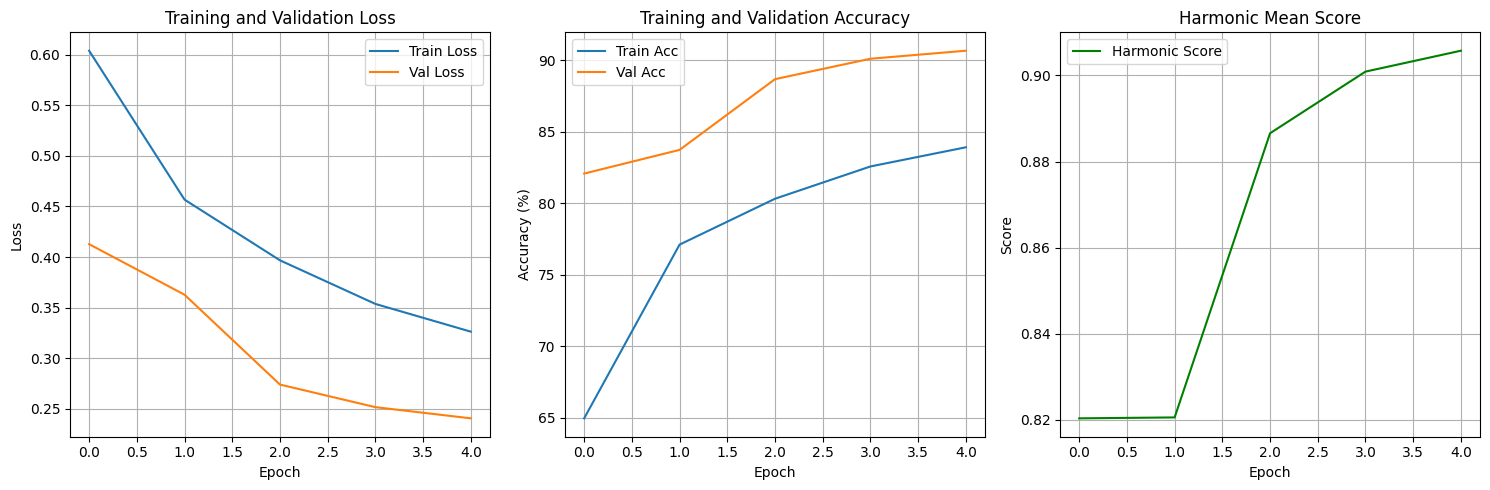

Making predictions...
Submission saved to submission.csv


In [12]:
train_dataset = AudioDataset('train_opus/audio', 'train_opus/word_bounds.json', mode='train')
test_dataset = AudioDataset('test_opus/audio', mode='test')

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

model = AudioClassifier(input_dim=80, num_classes=2, dim=256, num_blocks=2, heads=4)

print('Training model...')
trained_model = train_model(model, train_loader, val_loader, epochs=5, lr=3e-4)

print('Making predictions...')
predictions = predict(trained_model, test_loader)

create_submission(test_dataset.files, predictions)